---
## Models of Theoretical Physics
# Exercise Sheet 2 - Turing patterns

In this notebook, we'll look at the Activator Substrate Reaction Diffusion Model and observe varous properties associated with it
1. **Stability diagram**: 
    - From the linear stability analysis of partial differential equations, we will construct stability diagrams for different parameters, observing regimes where patterns are expected
2. **Turing Patterns**: 
    - We will simulate the 2D system on a spatial lattice for different parameters suggested by the stability phase plot to check for different patterns

---

The following codes have been taken from (c) 2019 Justin Bois and Michael Elowitz under [Creative Commons Attribution License CC-BY 4.0] (https://biocircuits.github.io/chapters/21_turing.html)

In [1]:
import numpy as np
import numba
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors

try:
    import rdsolver
except:
    print("Install rdsolver with 'pip install '")

In [2]:
%matplotlib inline

## Reaction-diffusion equations for two components

Consider two chemical components, U and V, that can react with each other. The dynamical equations we have considered thus far are of the form

\begin{align}
\frac{\mathrm{d}u}{\mathrm{d}t} &= f(u, v)\\[1em]
\frac{\mathrm{d}v}{\mathrm{d}t} &= g(u, v).
\end{align}

If the species can undergo diffusion, we need to include diffusive terms. We use Fick's second law, which says that the rate of change of concentration of a diffusing species is

\begin{align}
\frac{\partial c}{\partial t} = D\nabla^2 c,
\end{align}

to update our dynamical equations.

\begin{align}
\frac{\partial u}{\partial t} &= D_u\nabla^2 u + f(u, v)\\[1em]
\frac{\partial v}{\partial t} &= D_v\nabla^2 v + g(u, v).
\end{align}

Our goal is to determine what type of regulation we need in the chemical circuit (i.e., to decide what type of arrowheads, activating or repressing, to use in the figure below, and what values of $D_u$ and $D_v$ are necessary to give spontaneous patterning of U and V).


## Example: The Activator-Substrate Depletion Model

As an example of a system that undergoes a Turing pattern, let us consider now the activator-substrate depletion model, or ASDM. This is a simple model in which there are two species, the activator and substrate. The activator is autocatalytic, but consumes substrate in the process. It also has our standard degradation. The substrate is constitutively produced, and for the sake of simplicity, we assume it is very stable such that its degradation is all by consumption by the activator. This corresponds to the right circuit in our figure of circuits that can give Turing patterns, above. The dynamical equations are

\begin{align}
\frac{\partial a}{\partial t} &= D_a\,\nabla^2 a + \mu_a a^2s - \gamma a,\\[1em]
\frac{\partial s}{\partial t} &= D_s\,\nabla^2 s + \beta -  \mu_s a^2s.
\end{align}

We nondimensionalize by choosing $t \leftarrow t\gamma$, $(x,y,z) \leftarrow \sqrt{\gamma/D_s}(x, y, z)$, $a \leftarrow \gamma a/\beta$, $s \leftarrow \beta\rho s/\gamma^2$, $d = D_a/D_s$ and $\mu = \beta^2\mu_a^2/\gamma^3\mu_s$. Then, the dimensionless equations are

\begin{align}
\frac{\partial a}{\partial t} &= d \nabla^2 a + a^2s - a,\\[1em]
\frac{\partial s}{\partial t} &= \nabla^2 s + \mu(1-a^2s).
\end{align}

(Details of the nondimensionalization are shown in [Technical Appendix 3a](../technical_appendices/03a_nondimensionalization.ipynb).)
This system has a unique homogeneous steady state of $a_0 = s_0 = 1$.

The two dimensionless parameters have physical meaning. The parameter $d$ is the ratio of the diffusion coefficient of the activator to that of the substrate. Small $d$ means that the substrate diffuses much more rapidly than the activator. The parameter $\mu$ describes the relative rates of chemical reactions for substrate compared to activator.

In the language of our general Turing system, here we have $f_a = f_s = 1$, $g_a = -2\mu$, and $g_s = -\mu$, so we have a linear stability matrix

\begin{align}
\mathsf{A} = \begin{pmatrix}
1-dk^2 & 1 \\
-2\mu & -\mu-k^2
\end{pmatrix}.
\end{align}

### Linear stability diagram

We have just explored the parameter values that give patterns with interactive plots of the dispersion relation. We can take a similar approach to construct a **linear stability diagram**. There are two parameters, $\mu$ and $d$, and we can imagine a map of the $d$-$\mu$ plane identifying which regions of parameter space that have different linear stability properties. We have five possibilities in this system. Denoting by $k_\mathrm{max}$ the wave number for which the largest real part of the eigenvalues is (locally) maximal, we have the following.

|Eigenvalues | Description| color |
|:----:|:----|:----:|
|Negative real parts | Homogeneous steady state stable | <font color="#7fc97f">green</font> |
|Real, positive, $k_\mathrm{max}>0$ | Pattern forming | <font color="#beaed4">purple</font>|
|Real, positive, $k_\mathrm{max} = 0$| Homogeneous conc. grows without bound | <font color="#386cb0">blue</font>|
|Real, positive, $k_\mathrm{max} = 0$ and $k_\mathrm{max} > 0$ | Possible patterns, depending on initial condition | <font color="#ffff99">yellow</font> |
|Imaginary, $k_\mathrm{max} > 0$ | Oscillating homogeneous patterns | <font color="#fdc086">orange</font> |


In some cases, we can conveniently compute the boundaries between the different regions of parameter spaces, but it is often easier to take a "brute force" approach, wherein we compute the eigenvalues for each set of parameter values for a range of $k$-values, and then display the results as an image colored according to which class of eigenvalues we get. This is implemented below.

In [3]:
# Values for the plot
mu_vals = np.linspace(0.001, 2, 400)
d_vals = np.linspace(0.001, 0.5, 400)


@numba.njit
def region(d, mu):
    """Returns which region the eigenvalue lives in."""
    osc = False
    unstable = False
    turing = False

    if 3 - 2 * np.sqrt(2) < mu < 1:
        osc = True

    k2 = np.linspace(0, 10, 200)
    det = (1 - d * k2) * (-mu - k2) + 2 * mu
    tr = 1 - (1 + d) * k2 - mu

    real_lam = np.empty_like(k2)
    for i, (t, d) in enumerate(zip(tr, det)):
        discriminant = t ** 2 - 4 * d
        if discriminant < 0:
            real_lam[i] = t / 2
        else:
            real_lam[i] = (t + np.sqrt(discriminant)) / 2

    if (real_lam > 0).any():
        unstable = True

    if np.argmax(real_lam) > 0:
        turing = True

    if osc:
        if turing:
            return 3
        return 2

    if unstable:
        if turing:
            return 1
        return 4

    return 0


# Compute linear stability diagram
d, mu = np.meshgrid(d_vals, mu_vals)
im = np.empty_like(d)
for i in range(len(mu_vals)):
    for j in range(len(d_vals)):
        im[i, j] = region(d_vals[j], mu_vals[i])

In [4]:
pattern_dict = {0:"Homogenous",1:"Turing pattern",2:"Oscillating pattern",3:"Potential patterns",4:"Unbounded Growth"}

In [5]:
cmap_discrete = colors.ListedColormap(["#7fc97f", "#beaed4", "#fdc086", "#ffff99", "#386cb0"])
bounds = np.array([-0.5,0.5, 1.5, 2.5, 3.5,4.5])
norm = colors.BoundaryNorm(bounds, cmap_discrete.N)

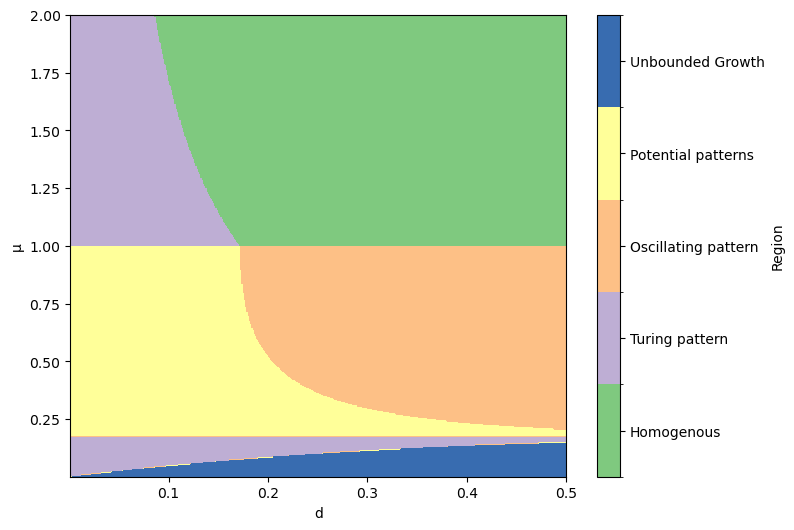

In [6]:
plt.close('all')
fig,ax = plt.subplots(figsize=(8,6))
img = plt.imshow(im, origin="lower", extent=[d.min(), d.max(), mu.min(), mu.max()],cmap=cmap_discrete, aspect="auto",norm=norm)
plt.xlabel("d")
plt.ylabel("µ")
cbar = plt.colorbar(img, ticks=[0,1,2,3,4], boundaries=bounds, label="Region")
cbar.ax.set_yticklabels(pattern_dict.values())

# plt.axvline(0.1)
# plt.axhline(0.2)

plt.show()

### Two-dimensional solutions

Using more sophisticated numerical integration techniques, we can solve the ADSM in two dimensions. This is implemented in the [rdsolver package](https://github.com/justinbois/rdsolver), which solves two-dimensional reaction-diffusion problems using [spectral methods](https://en.wikipedia.org/wiki/Spectral_method) with implicit-explicit (IMEX) time stepping. For fun, we demonstrate it here.

In [7]:
@numba.jit(nopython=True)
def f(u, t, mu):
    """Nonlinear terms for ASDM"""
    a = u[0,:,:]
    s = u[1,:,:]
    return np.stack((a**2 * s, -mu * a**2 * s))

In [8]:
# Set up the space and time grid
n = (32, 32)
L = (20, 20)

In [9]:
## Pattern : Small Spots


d = 0.05
mu = 1.01

uniform_conc = (1,1)
t = np.linspace(0, 250, 500)

In [10]:
D = (d, 1)
beta = (0, mu)
gamma = np.array([[-1, 0], [0, 0]])
f_args = (mu, )

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=uniform_conc, n=n, L=L)

c_spots = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L,quiet=True)

100%|██████████| 500/500 [00:18<00:00, 26.39it/s] 


In [11]:
# Interpolate the solution
c_spots_interp = rdsolver.viz.interpolate_concs(c_spots)

minconc,maxconc = np.min(c_spots_interp[:,:,:,-1]),np.max(c_spots_interp[:,:,:,-1])

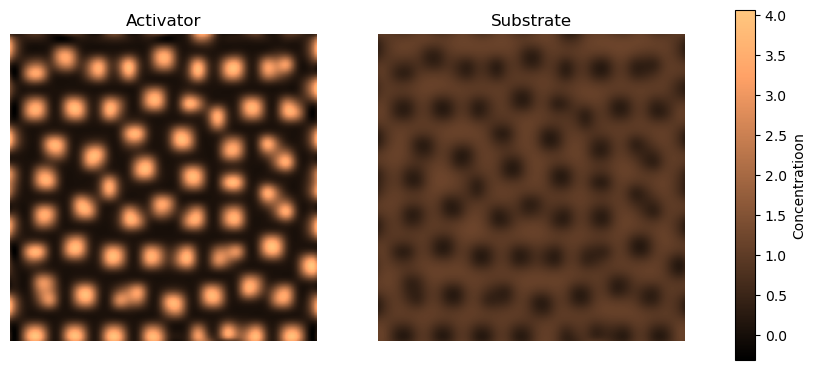

In [12]:
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(10,5))

im0 = ax[0].imshow(c_spots_interp[0,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[0].set_title("Activator")
ax[0].set_axis_off()
                      
im1 = ax[1].imshow(c_spots_interp[1,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[1].set_title("Substrate")
ax[1].set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax,label="Concentratioon")

plt.show()

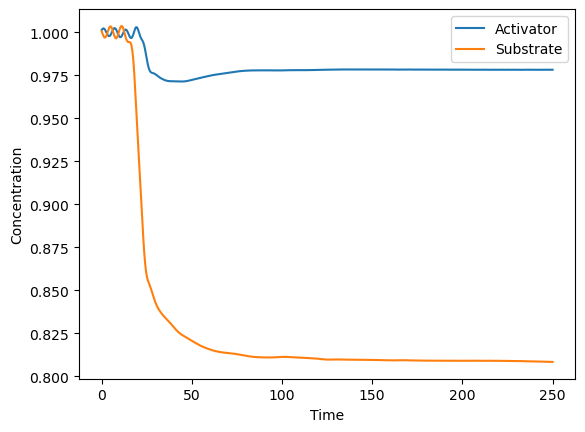

In [13]:
plt.close('all')
labels = ["Activator","Substrate"]

plt.plot(t,np.mean( c_spots_interp[0,:,:,:], axis=(0,1)), label = labels[0])
plt.plot(t,np.mean( c_spots_interp[1,:,:,:], axis=(0,1)), label = labels[1])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

In [14]:
def init():
    im.set_data(c_spots_interp[0,:,:,0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=c_spots_interp[0,:,:,i]
    im.set_array(a)
    return [im]

In [15]:
%matplotlib widget

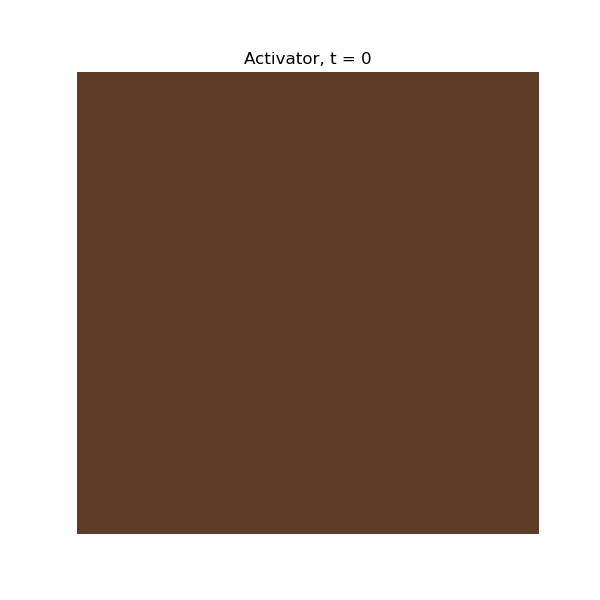

In [16]:
plt.close('all')

fig,ax = plt.subplots( figsize=(6,6) )

fps = 60
snapshots = [ c_spots_interp[0,:,:,i] for i in range( len(t) ) ]

a = snapshots[0]
im = plt.imshow(a, cmap=plt.cm.copper, vmin=minconc, vmax=maxconc, extent=[0,L[0],0,L[0]])
ax.set_axis_off()
ax.set_title("Activator, t = 0")

def animate_func(i):
    im.set_array(snapshots[i])
    ax.set_title("Activator, t = %.2f" %(t[i]))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len( snapshots ),interval = 1000 / fps,repeat=False)

# anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

plt.show()



In [17]:
## Pattern : Waves 
d = 0.1
mu = 1.2

uniform_conc = (1,1)
t = np.linspace(0, 500, 1000)

In [18]:
D = (d, 1)
beta = (0, mu)
gamma = np.array([[-1, 0], [0, 0]])
f_args = (mu, )

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=uniform_conc, n=n, L=L)

c_waves = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L,quiet=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 171.41it/s]


In [19]:
# Interpolate the solution
c_waves_interp = rdsolver.viz.interpolate_concs(c_waves)

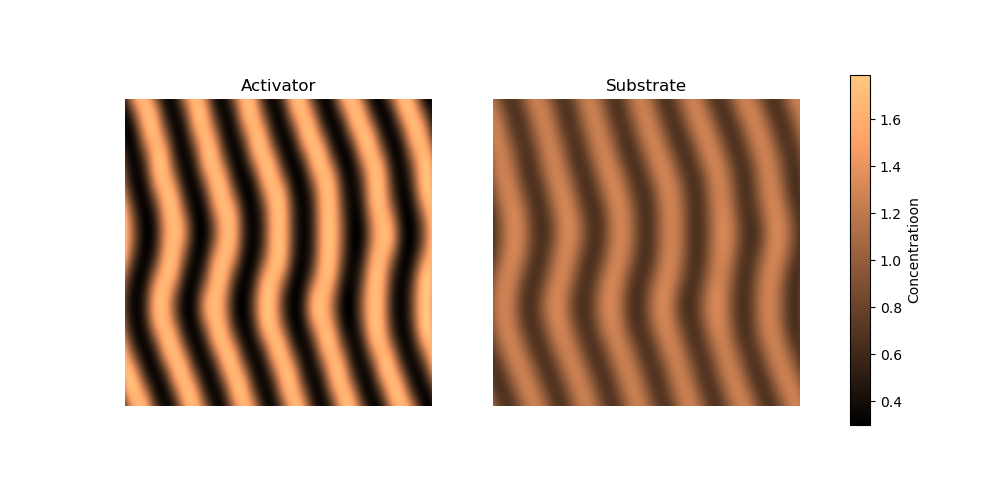

In [20]:
minconc,maxconc = np.min(c_waves_interp[:,:,:,-1]),np.max(c_waves_interp[:,:,:,-1])
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(10,5))

im0 = ax[0].imshow(c_waves_interp[0,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[0].set_title("Activator")
ax[0].set_axis_off()
                      
im1 = ax[1].imshow(c_waves_interp[1,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[1].set_title("Substrate")
ax[1].set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax,label="Concentratioon")

plt.show()

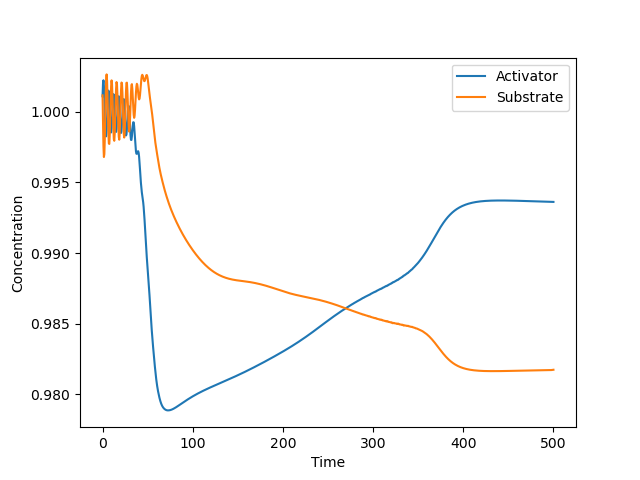

In [21]:
plt.close('all')
labels = ["Activator","Substrate"]

plt.plot(t,np.mean( c_waves_interp[0,:,:,:], axis=(0,1)), label = labels[0])
plt.plot(t,np.mean( c_waves_interp[1,:,:,:], axis=(0,1)), label = labels[1])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

In [22]:
minconc,maxconc = np.min(c_waves_interp[:,:,:,-1]),np.max(c_waves_interp[:,:,:,-1])

In [23]:
def init():
    im.set_data(c_waves_interp[0,:,:,0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=c_waves_interp[0,:,:,i]
    im.set_array(a)
    return [im]

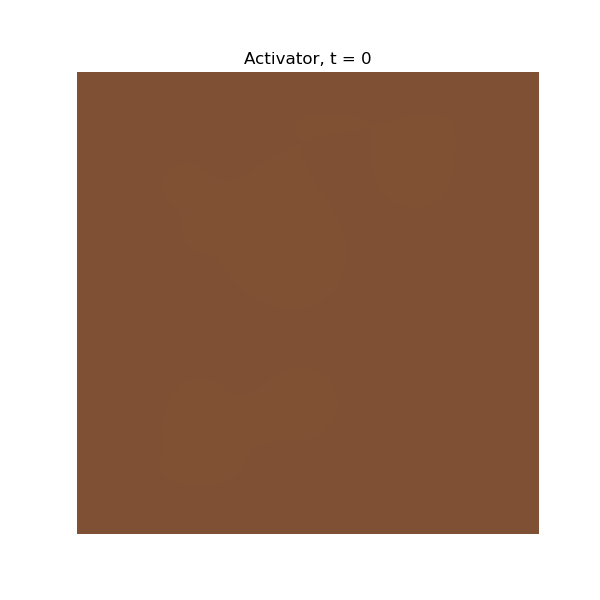

In [24]:
plt.close('all')

fig,ax = plt.subplots( figsize=(6,6) )

fps = 90
snapshots = [ c_waves_interp[0,:,:,i] for i in range( len(t) ) ]

a = snapshots[0]
im = plt.imshow(a, cmap=plt.cm.copper, vmin=minconc, vmax=maxconc, extent=[0,L[0],0,L[0]])
ax.set_axis_off()
ax.set_title("Activator, t = 0")

def animate_func(i):
    im.set_array(snapshots[i])
    ax.set_title("Activator, t = %.2f" %(t[i]))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len( snapshots ),interval = 1000 / fps,repeat=False)

# anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

plt.show()



In [22]:
## Pattern : Pulsing Waves


d = 0.15
mu = 1.01

uniform_conc = (1,1)
t = np.linspace(0, 400, 1000)

In [23]:
D = (d, 1)
beta = (0, mu)
gamma = np.array([[-1, 0], [0, 0]])
f_args = (mu, )

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=uniform_conc, n=n, L=L)

c_pwaves = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L,quiet=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 152.86it/s]


In [24]:
# Interpolate the solution
c_pwaves_interp = rdsolver.viz.interpolate_concs(c_pwaves)

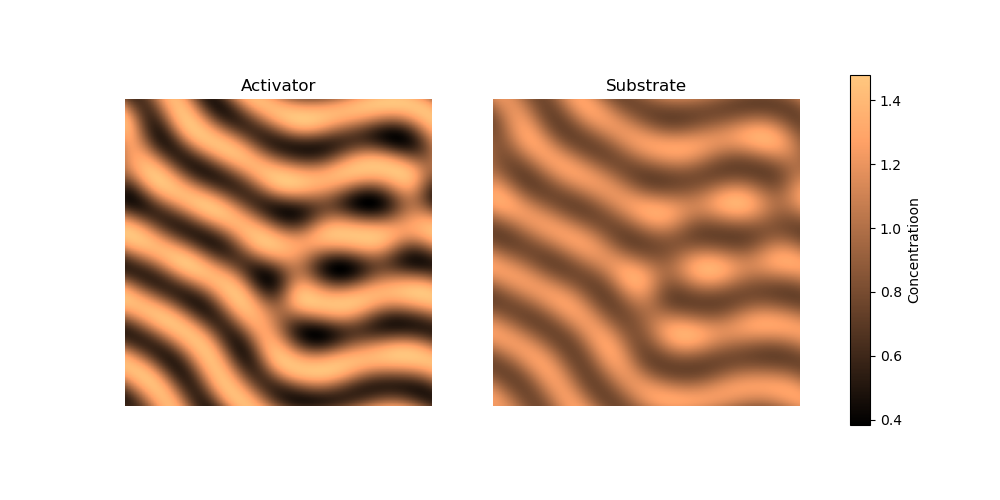

In [25]:
minconc,maxconc = np.min(c_pwaves_interp[:,:,:,-1]),np.max(c_pwaves_interp[:,:,:,-1])
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(10,5))

im0 = ax[0].imshow(c_pwaves_interp[0,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[0].set_title("Activator")
ax[0].set_axis_off()
                      
im1 = ax[1].imshow(c_pwaves_interp[1,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0],0,L[0]])
ax[1].set_title("Substrate")
ax[1].set_axis_off()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax,label="Concentratioon")

plt.show()

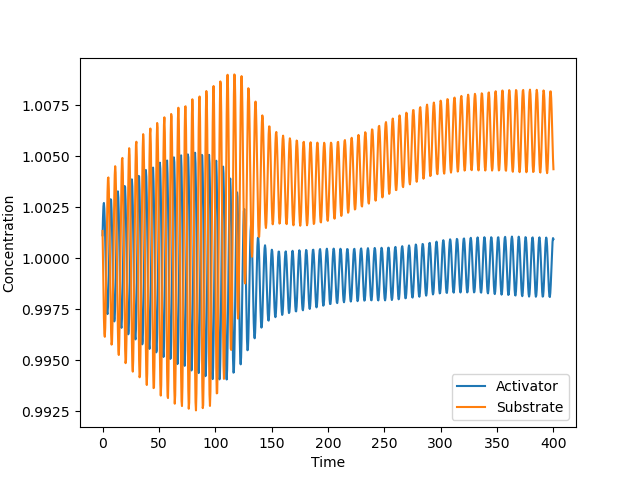

In [26]:
plt.close('all')
labels = ["Activator","Substrate"]

plt.plot(t,np.mean( c_pwaves_interp[0,:,:,:], axis=(0,1)), label = labels[0])
plt.plot(t,np.mean( c_pwaves_interp[1,:,:,:], axis=(0,1)), label = labels[1])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

In [27]:
minconc,maxconc = np.min(c_pwaves_interp[:,:,:,-1]),np.max(c_pwaves_interp[:,:,:,-1])

In [28]:
def init():
    im.set_data(c_pwaves_interp[0,:,:,0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=c_pwaves_interp[0,:,:,i]
    im.set_array(a)
    return [im]

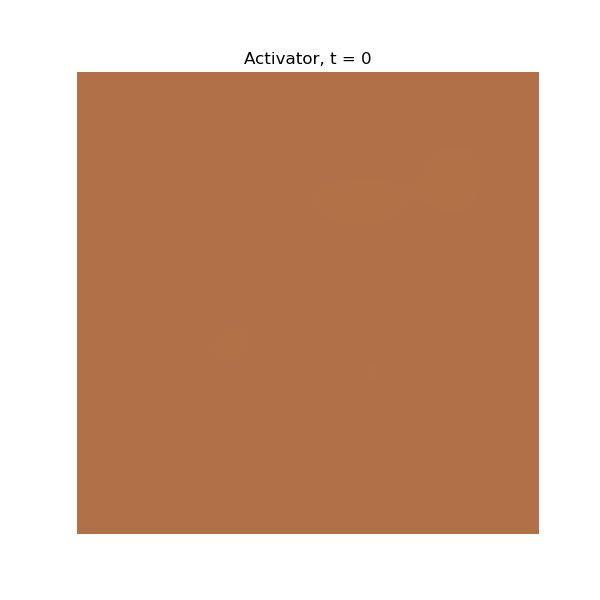

In [29]:
plt.close('all')

fig,ax = plt.subplots( figsize=(6,6) )

fps = 75
snapshots = [ c_pwaves_interp[0,:,:,i] for i in range( len(t) ) ]

a = snapshots[0]
im = plt.imshow(a, cmap=plt.cm.copper, vmin=minconc, vmax=maxconc, extent=[0,L[0],0,L[0]])
ax.set_axis_off()
ax.set_title("Activator, t = 0")

def animate_func(i):
    im.set_array(snapshots[i])
    ax.set_title("Activator, t = %.2f" %(t[i]))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len( snapshots ),interval = 1000 / fps,repeat=False)

# anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

plt.show()



In [30]:
# Set up the space and time grid
n = (32, 32)
L = (100, 20)

In [31]:
## Pattern : Large Pulsing Waves


d = 0.15
mu = 1.01

uniform_conc = (1,1)
t = np.linspace(0, 5000, 1000)

In [32]:
D = (d, 1)
beta = (0, mu)
gamma = np.array([[-1, 0], [0, 0]])
f_args = (mu, )

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=uniform_conc, n=n, L=L)

c_largepwaves = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L,quiet=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:41<00:00, 24.02it/s]


In [33]:
# Interpolate the solution
c_largepwaves_interp = rdsolver.viz.interpolate_concs(c_largepwaves)

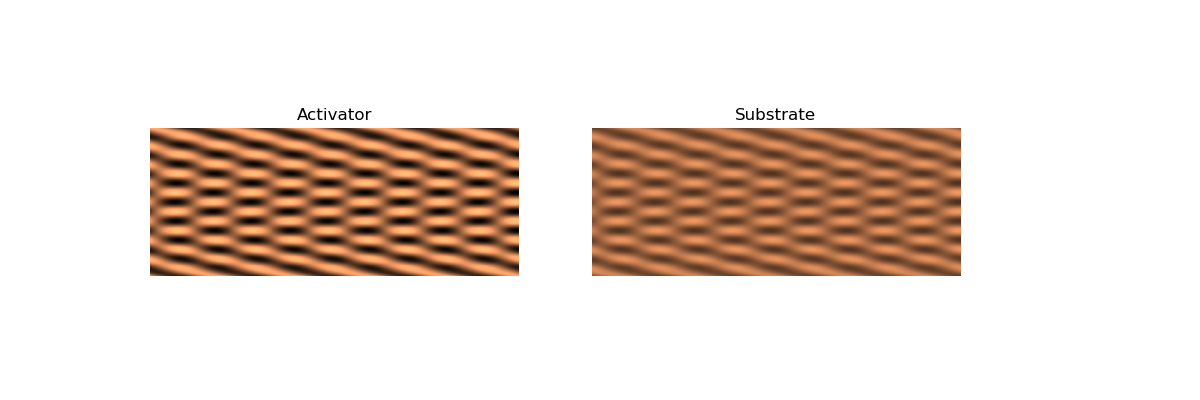

In [34]:
minconc,maxconc = np.min(c_largepwaves_interp[:,:,:,-1]),np.max(c_largepwaves_interp[:,:,:,-1])
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(12,4))

im0 = ax[0].imshow(c_largepwaves_interp[0,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0]/2,0,L[1]])
ax[0].set_title("Activator")
ax[0].set_axis_off()
                      
im1 = ax[1].imshow(c_largepwaves_interp[1,:,:,-1],cmap='copper',vmin=minconc,vmax=maxconc,extent=[0,L[0]/2,0,L[1]])
ax[1].set_title("Substrate")
ax[1].set_axis_off()

fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15*(L[1]-L[0]), 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax,label="Concentratioon")

plt.show()

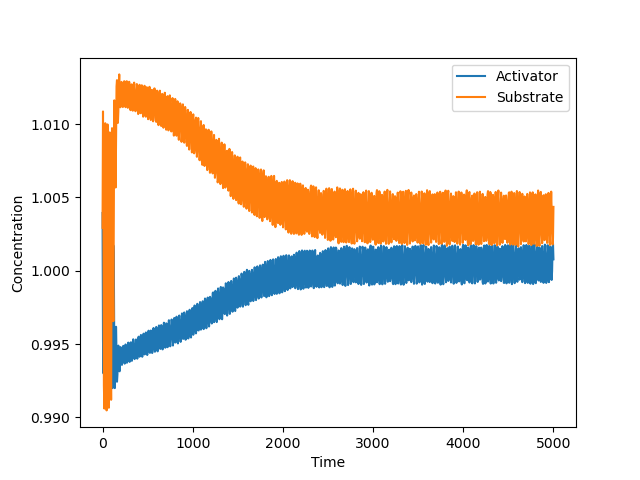

In [35]:
plt.close('all')
labels = ["Activator","Substrate"]

plt.plot(t,np.mean( c_largepwaves_interp[0,:,:,:], axis=(0,1)), label = labels[0])
plt.plot(t,np.mean( c_largepwaves_interp[1,:,:,:], axis=(0,1)), label = labels[1])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show()

In [36]:
minconc,maxconc = np.min(c_largepwaves_interp[:,:,:,-1]),np.max(c_largepwaves_interp[:,:,:,-1])

In [37]:
def init():
    im.set_data(c_largepwaves_interp[0,:,:,0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=c_largepwaves_interp[0,:,:,i]
    im.set_array(a)
    return [im]

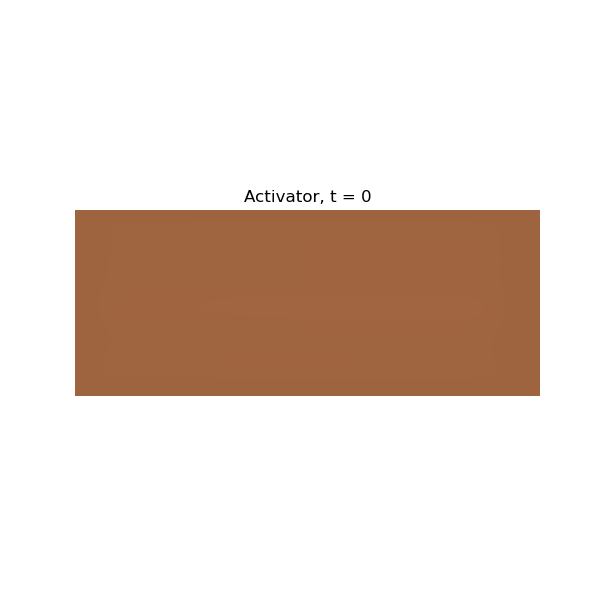

In [38]:
plt.close('all')

fig,ax = plt.subplots( figsize=(6,6) )

fps = 60
snapshots = [ c_largepwaves_interp[0,:,:,i] for i in range( len(t) ) ]

a = snapshots[0]
im = plt.imshow(a, cmap=plt.cm.copper, vmin=minconc, vmax=maxconc, extent=[0,L[0]/2,0,L[1]])
ax.set_axis_off()
ax.set_title("Activator, t = 0")

def animate_func(i):
    im.set_array(snapshots[i])
    ax.set_title("Activator, t = %.2f" %(t[i]))
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len( snapshots ),interval = 1000 / fps,repeat=False)

# anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

plt.show()



### More Complicated model

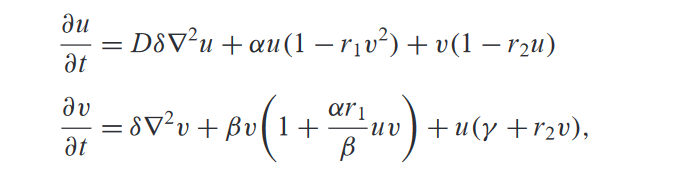

**Try this on your own in case you are interested**
